### Visualizing Behavior

#### J. Carpenter 2020

### Load data:

In [25]:
# import libraries
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [26]:
# Load dataset
fileLoc = "D:\\Data\\Dataset\\24116.mat"
matfile = sio.loadmat(fileLoc) # load .mat file

### Define functions:

In [27]:
def instFR(matfile, sigma, sessNum, unitNum):
    # spikeTrain for a single session
    # Fs: sampling frequency
    import scipy.ndimage
    from scipy import stats

    SpikeTrain = matfile["SpikeTrain"][0] 
    spikesNow = SpikeTrain[sessNum][0][unitNum][0] # grab spikes for session 
    
    # get sampling frequency
    pos = matfile["pos"][0]
    t = pos[sessNum][:,0] # grab time vector
    Fs, cnt = stats.mode(np.diff(t)) # calc mode of sampling frequencies
    
    # compute instantaneous FR
    firingRate = spikesNow/Fs # in Hz (spikes/second)
    
    # smooth rate with a Gaussian kernel (100 or 200 ms)
    smoothRate = scipy.ndimage.gaussian_filter1d(firingRate, sigma)
    
    return smoothRate

In [28]:
def makeDF(matfile, sessNum, unitNum):
    # make dataframe to pass through plotly for one session
    # this may be too computationally heavy
    
    pos = matfile["pos"][0] # time & LEDs
    time = pos[sessNum][:,0]
    led1A = pos[sessNum][:,1]; led1B = pos[sessNum][:,2];
    led2A = pos[sessNum][:,3]; led2B = pos[sessNum][:,4];
      
    SpikeTrain = matfile["SpikeTrain"][0][sessNum][0]    
    if np.size(SpikeTrain) > 0: 
        SpikeTrainUnit = SpikeTrain[unitNum][0]
        d = {'time': time, 'led1A': led1A , 'led1B': led1B, 'led2A': led2A, 'led2B': led2B, 'spikes:': SpikeTrainUnit}
    else:
        d = {'time': time, 'led1A': led1A , 'led1B': led1B, 'led2A': led2A, 'led2B': led2B}
    df = pd.DataFrame(data=d)
    
    return df

In [29]:
# def makeAnimation(df):
#     px.scatter(df, x="led1A", y="led1B", animation_frame="time")

In [30]:
def getUnitData(matfile, sessNum, unitNum):
    
    """
    The following data will be loaded (via scipy.io):
    
        'SpikeTrain':    Sx1 array, where S is the number of sessions for the animal. 
                         Each session (S) contains a Nx1 vector, where N is the number of 
                         neurons (units) recorded in a given session.
                      
        'pos':           Sx1 array containing information about time and the positions of 2 LEDs.
        
        'UniqueID':      Sx1 array, where each array contains an Nx1 vector. Each element is a 
                         string value, containing the unique cell ID for the given unit.
        
        'trialType':    Sx1 array, containing a string value of session type (FM or OF, for
                        'Foster Maze' or 'Open Field', respectively. 'TS' might also be present,
                         which stands for 'Training Session'.
                         
    Outputs:
    
        'time':         tx1 array, where t is the number of timestamps for the session.
    """
    
        
    # pull out relevant arrays
    SpikeTrain = matfile["SpikeTrain"][0]
    pos = matfile["pos"][0] # time & LEDs
    UniqueID = matfile["UniqueID"][0]
    trialType = matfile["trialType"][0]
    
    
    # trial type, spike train, unique ID #
    spikesNow = SpikeTrain[sessNum][0][unitNum][0]
    trialNow = str(trialType[sessNum][0])
    idNow = str(UniqueID[sessNum][0][unitNum][0][0])
    info = [idNow, sessNum, trialNow]
    
    # get window maximums and minumums
    minX = float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0])
    maxX = float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0])
    minY = float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0])
    maxY = float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0])
    window = np.array([minX, maxX, minY, maxY])
    
    return window, spikesNow, info

In [31]:
def getTimePt(matfile, sessNum, timePoint):
    
    # parse position vector
    pos = matfile["pos"][0]
    time = pos[sessNum][:,0][timePoint];
    led1A = pos[sessNum][:,1][timePoint]; led1B = pos[sessNum][:,2][timePoint];
    led2A = pos[sessNum][:,3][timePoint]; led2B = pos[sessNum][:,4][timePoint];
    led = np.array([time, led1A, led1B, led2A, led2B])
    
    return time, led

In [32]:
def plotBehavior(led, window, info):
    """
    plots behavior for a single timepoint.
    """
    
    # parse window vector
    minX = window[0]; maxX = window[1]; minY = window[2]; maxY = window[3]
    
    # parse led vector
    time = led[0]
    L1A = led[1]; L1B = led[2]; L2A = led[3]+10; L2B = led[4]+10 # offset second LED
    
    # make title
    plot_title = 'uid:' + str(info[0]) + ' / sess:' + str(info[1]) + ' / type:' + str(info[2]) + '/ t(ms):' + str(time)
    
    # plot LEDs at timepoint
    fig, ax = plt.subplots(figsize = (6,6))
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    ax.hlines(y = minY, xmin = minX, xmax = maxX, linestyles='dashed') #minY
    ax.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles='dashed') # maxY
    ax.vlines(x = minX, ymin = minY, ymax = maxY, linestyles='dashed') # minX
    ax.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles='dashed') # maxX
    
    ax.scatter(L1A, L1B, s=25, c='red')
    ax.scatter(L2A, L2B, s=25, c='blue')
    
    font = {'fontname':'Helvetica'}
    ax.set_xlabel("x", **font, fontsize=14);
    ax.set_ylabel("y", **font, fontsize=14);
    ax.set_title(plot_title, **font,fontsize=16);
    ax.axis('square')
    
    # save figure
    pngName = 'D:\\behaviorVideos\\24116\\' + str(time) + '.png'
    fig.savefig(pngName)
    
    # close figure
    plt.close()
    
    return

In [33]:
def makeSpikePlot(matfile, sessNum, unitNum, timePoint):
    
    SpikeTrain = matfile["SpikeTrain"][0]
    spikesNow = SpikeTrain[sessNum][0][unitNum][0]
    pos = matfile["pos"][0]
    time = pos[sessNum][:,0][timePoint];

In [8]:
def genImage(matfile, sessNum, unitNum):
    # generate & save .png
    
    SpikeTrain = matfile["SpikeTrain"][0][sessNum][0]
    window, spikesNow, info = getUnitData(matfile, sessNum, unitNum) 
    
    for timePoint in range(0,len(spikesNow)): # fix this
        time, led = getTimePt(matfile, sessNum, timePoint)
        plotBehavior(led, window, info)

(array([1.10707e+05, 2.28000e+02, 7.30000e+01, 6.00000e+00, 7.00000e+00,
        8.00000e+00, 3.00000e+00, 2.00000e+00, 5.00000e+00, 5.00000e+00]),
 array([ 0.       ,  4.5751715,  9.150343 , 13.7255145, 18.300686 ,
        22.8758575, 27.451029 , 32.0262005, 36.601372 , 41.1765435,
        45.751715 ]),
 <a list of 10 Patch objects>)

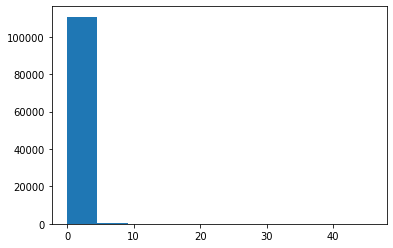

In [192]:
# plot that shit
SR = instFR(matfile, 2, 25, 1)
fig, ax = plt.subplots()
# ax.plot(t, SR);
ax.hist(SR)

### Generate images:

In [ ]:
genImage(matfile, 12, 4) # try session 13, cell 5